In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np 
import matplotlib.pyplot as plt
import json, re, os
%matplotlib inline
plt.rcParams['figure.figsize'] = 8,8

from ulConnect import getULData
from WatchDog import getAllSOH, getSOH
from datetime import datetime, timedelta
from pprint import pprint

# First: get all the stock on hand as of 1/2/19

In [2]:
def get_soh_as_of_date(date_string=None):
    r = getULData('StockOnHand/','pageSize=1000')
    pages = r.json()['Pagination']['NumberOfPages']
    if not date_string:
        date_string = str(datetime.now().year)+'-'+str(datetime.now().month)+'-'+str(datetime.now().day)
    # Get a request list of Sales Orders by
    # looping through pages and get all POs
    soh = []
    for i in range(1,pages+1):
        # print(i)
        r = getULData('StockOnHand/'+str(i), 'pageSize=1000&asAtDate='+date_string)
        # print(r, r.url)
        for item in r.json()['Items']:
            if item not in soh:
                soh.append(item)
    if os.path.isfile('stockOnHand_'+date_string+'.json'):
        os.remove('stockOnHand_'+date_string+'.json')
    with open('stockOnHand_'+date_string+'.json', 'w') as outfile:
        json.dump(soh, outfile)

    return(soh)

In [3]:
def get_all_products():
    r = getULData('Products/','pageSize=1000')
    pages = r.json()['Pagination']['NumberOfPages']
    # Get a request list of products by
    # looping through pages and get all listed products
    products = []
    for i in range(1,pages+1):
        # print(i)
        r = getULData('Products/'+str(i), 'pageSize=1000')
        for item in r.json()['Items']:
            if item not in products:
                products.append(item)
    if os.path.isfile('products.json'):
        os.remove('products.json')
    with open('products.json', 'w') as outfile:
        json.dump(products, outfile)

    return(products)

In [4]:
initial_stock = get_soh_as_of_date(date_string='2019-02-28')

In [5]:
pprint(initial_stock[0])

{'AllocatedQty': 0.0,
 'AvailableQty': 4.0,
 'AvgCost': 3.38,
 'DaysSinceLastSale': 169,
 'Guid': '594091f0-c613-42ff-9433-49337bf7be32',
 'LastModifiedOn': '/Date(1564057822394)/',
 'OnPurchase': 0.0,
 'ProductCode': "10' Pad6314",
 'ProductDescription': "Padco Refill Lambskin 10'",
 'ProductGroupName': 'Applicators',
 'ProductGuid': '594091f0-c613-42ff-9433-49337bf7be32',
 'ProductSourceId': None,
 'QtyOnHand': 4.0,
 'TotalCost': 13.52,
 'Warehouse': '',
 'WarehouseCode': '',
 'WarehouseId': ''}


# Put this information in a dataframe

In [6]:
initial_stock_df = pd.read_json(json.dumps(initial_stock))

In [7]:
initial_stock_df.head()


AllocatedQty  AvailableQty  AvgCost  DaysSinceLastSale  \
0           0.0           4.0  3.38000              169.0   
1           0.0          10.0  3.84000              405.0   
2           0.0          13.0  5.25000              252.0   
3           0.0         190.0  5.59000              197.0   
4           0.0          60.0  5.83285              232.0   

                                   Guid         LastModifiedOn  OnPurchase  \
0  594091f0-c613-42ff-9433-49337bf7be32  /Date(1564057822394)/         0.0   
1  5d6c26aa-f64d-4237-94a8-598449b2a2c0  /Date(1563218821284)/         0.0   
2  61b7111f-4eb3-469c-a946-14938398b151  /Date(1544736064492)/         0.0   
3  b0ad60e3-4322-439f-9bfb-0d5a6f0785a5  /Date(1562783116596)/         0.0   
4  56f3791c-55a8-464e-bac5-17b005d71a96  /Date(1562946750077)/         0.0   

      ProductCode                     ProductDescription ProductGroupName  \
0     10' Pad6314              Padco Refill Lambskin 10'      Applicators   
1     12' Pad6316              Padco Refill Lambskin 12'      Applicators   
2     16' Pad6320              Padco Refill Lambskin 16'      Applicators   
3  3MBelReg729100  7-7/8'x29-1/2' 100 Grit Regalite belt        Sandpaper   
4  3mBelReg729120  7-7/8'x29-1/2' 120 Grit Regalite belt        Sandpaper   

                            ProductGuid  ProductSourceId  QtyOnHand  \
0  594091f0-c613-42ff-9433-49337bf7be32              NaN        4.0   
1  5d6c26aa-f64d-4237-94a8-598449b2a2c0              NaN       10.0   
2  61b7111f-4eb3-469c-a946-14938398b151              NaN       13.0   
3  b0ad60e3-4322-439f-9bfb-0d5a6f0785a5              NaN      190.0   
4  56f3791c-55a8-464e-bac5-17b005d71a96              NaN       60.0   

   TotalCost Warehouse WarehouseCode WarehouseId  
0     13.520                                      
1     38.400                                      
2     68.250                                      
3   1062.100                                      
4    349.971

## Group by product categories and sum by totals

In [20]:
total_values_df = initial_stock_df[['ProductGroupName', 'TotalCost']].groupby('ProductGroupName').sum()
initial_total_values_df = initial_stock_df[['ProductGroupName', 'TotalCost']].groupby('ProductGroupName').sum()
in_val = total_values_df.TotalCost.sum()

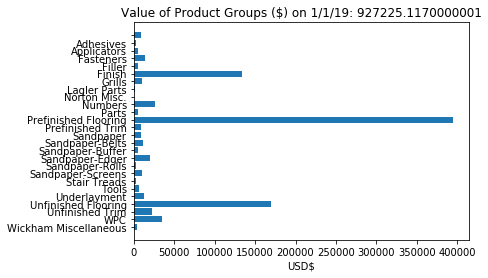

In [9]:
fig, ax = plt.subplots()

pgs = total_values_df.index
y_pos = np.arange(len(pgs))
totals = total_values_df.TotalCost.values

ax.barh(y_pos, totals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(pgs)
ax.invert_yaxis()
ax.set_xlabel('USD$')
ax.set_title('Value of Product Groups ($) on 1/1/19: '+str(in_val))

plt.show()

In [10]:
# current_inventory = get_soh_as_of_date(date_string='2019-04-30')

In [11]:
current_inventory_df = pd.read_json('stockOnHand_2019-7-16.json')
current_total_values_df = current_inventory_df[['ProductGroupName', 'TotalCost']].groupby('ProductGroupName').sum()
in_val = current_total_values_df.TotalCost.sum()

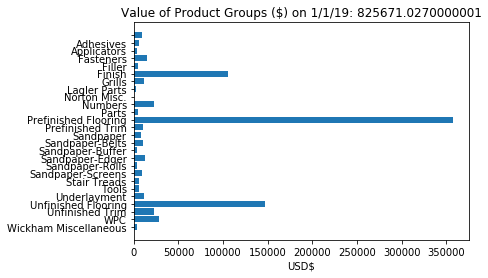

In [12]:
fig, ax = plt.subplots()

pgs_0 = current_total_values_df.index
y_pos_0 = np.arange(len(pgs))
totals_0 = current_total_values_df.TotalCost.values

ax.barh(y_pos_0, totals_0, align='center')
ax.set_yticks(y_pos_0)
ax.set_yticklabels(pgs_0)
ax.invert_yaxis()
ax.set_xlabel('USD$')
ax.set_title('Value of Product Groups ($) on 1/1/19: '+str(in_val))

plt.show()

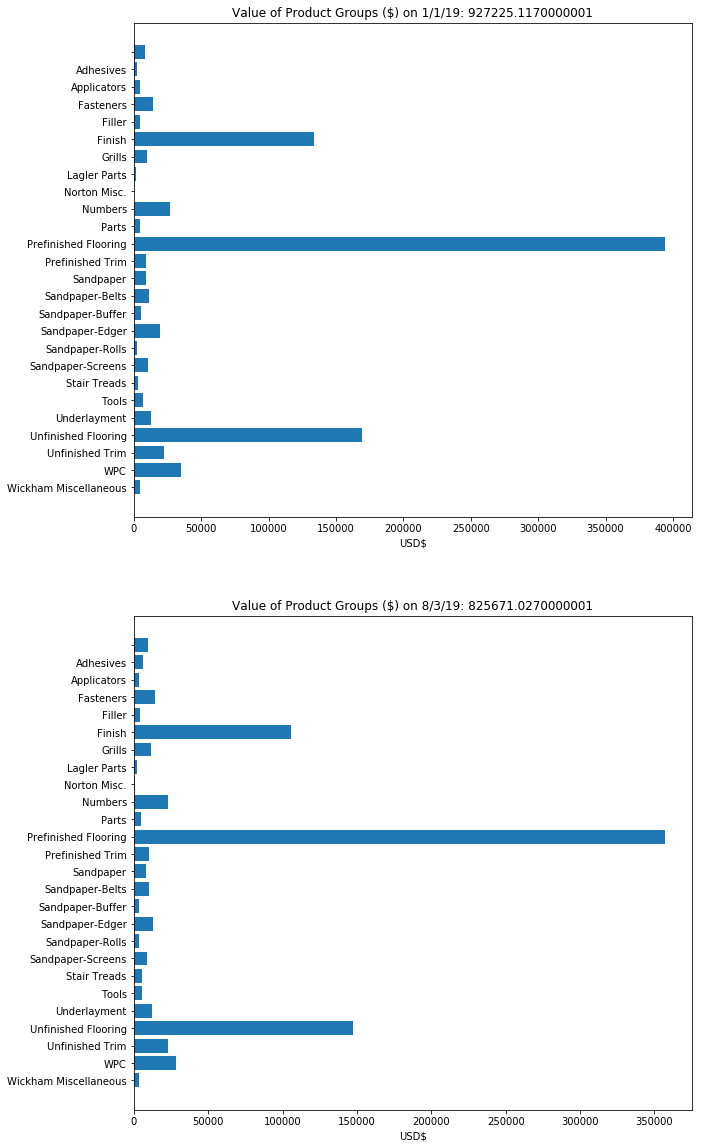

In [13]:
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(10,20))

in_val_0 = total_values_df.TotalCost.sum()
pgs_0 = total_values_df.index
y_pos_0 = np.arange(len(pgs))
totals_0 = total_values_df.TotalCost.values

ax[0].barh(y_pos_0, totals_0, align='center')
ax[0].set_yticks(y_pos_0)
ax[0].set_yticklabels(pgs_0)
ax[0].invert_yaxis()
ax[0].set_xlabel('USD$')
ax[0].set_title('Value of Product Groups ($) on 1/1/19: '+str(in_val_0))

in_val = current_total_values_df.TotalCost.sum()
pgs = current_total_values_df.index
y_pos = np.arange(len(pgs))
totals = current_total_values_df.TotalCost.values

ax[1].barh(y_pos, totals, align='center')
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(pgs)
ax[1].invert_yaxis()
ax[1].set_xlabel('USD$')
ax[1].set_title('Value of Product Groups ($) on 8/3/19: '+str(in_val))





plt.show()

In [14]:
import seaborn as sns

In [15]:
change_df = pd.concat([total_values_df,current_total_values_df], axis=1)
change_df.columns = ['Initial', 'Final']

In [16]:
change_df.head()

Initial      Final
ProductGroupName                      
                   8595.823   9526.143
Adhesives          2601.734   5883.535
Applicators        4673.072   3276.515
Fasteners         14225.160  14483.907
Filler             4839.136   4168.975

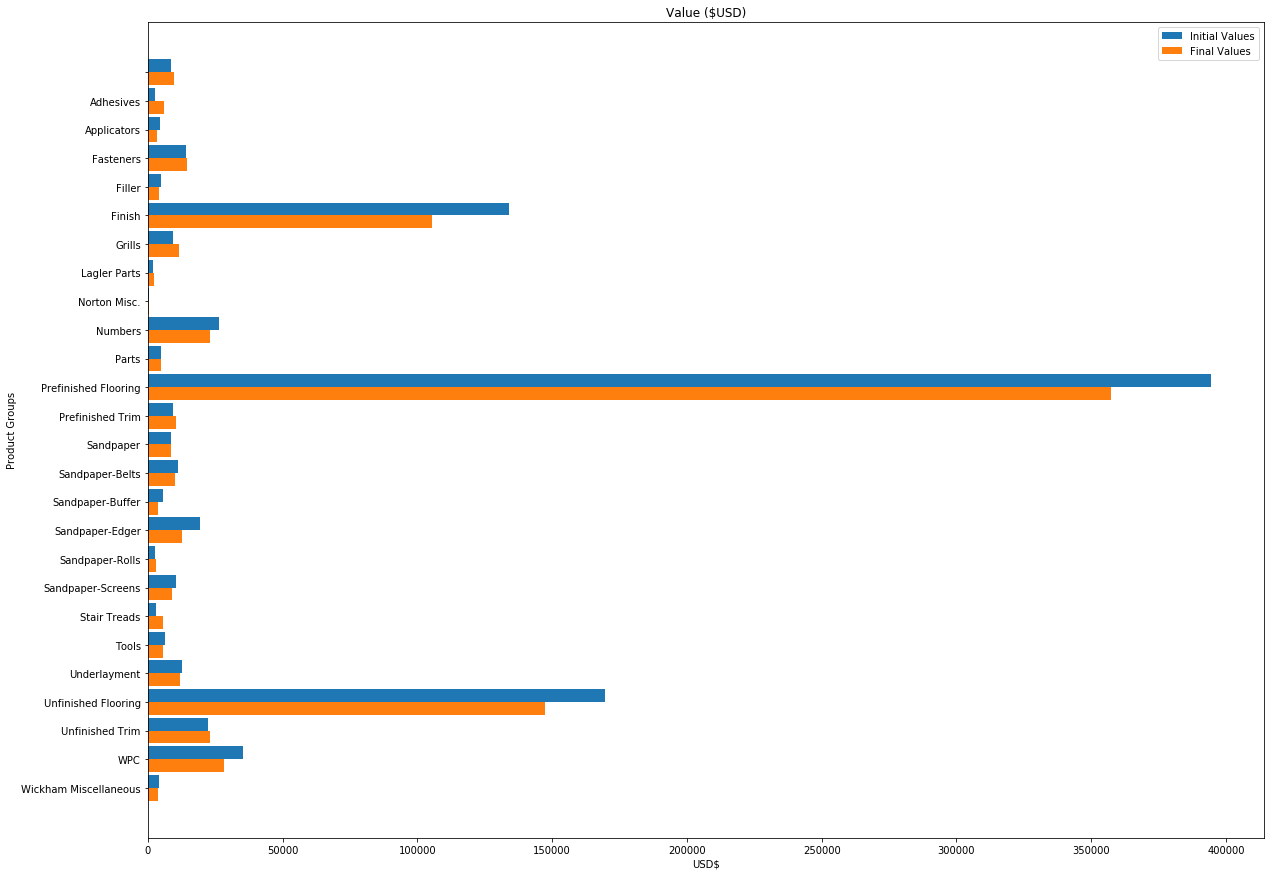

In [17]:
labels = change_df.index
initial_values = change_df.Initial
final_values= change_df.Final

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(20,15))
rects1 = ax.barh(x - width/2, initial_values, width, label='Initial Values')
rects2 = ax.barh(x + width/2, final_values, width, label='Final Values')

pgs = current_total_values_df.index
y_pos = np.arange(len(pgs))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Product Groups')
ax.set_title('Value ($USD)')
ax.set_yticks(y_pos)
ax.set_yticklabels(pgs)
ax.invert_yaxis()
ax.set_xlabel('USD$')
ax.legend()

plt.show()

# in_val = current_total_values_df.TotalCost.sum()
# pgs = current_total_values_df.index
# y_pos = np.arange(len(pgs))
# totals = current_total_values_df.TotalCost.values

# ax[1].barh(y_pos, totals, align='center')
# ax[1].set_yticks(y_pos)
# ax[1].set_yticklabels(pgs)
# ax[1].invert_yaxis()
# ax[1].set_xlabel('USD$')
# ax[1].set_title('Value of Product Groups ($) on 8/3/19: '+str(in_val))

In [21]:
diff_df = pd.DataFrame()
initial_total_values_df.rename(columns={'TotalCost':'InitialTotalCost'}, inplace=True)
current_total_values_df.rename(columns={'TotalCost':'CurrentTotalCost'}, inplace=True)
diff_df = pd.concat([diff_df,initial_total_values_df,current_total_values_df], axis=1)

In [22]:
diff_df['Difference'] = diff_df.InitialTotalCost - diff_df.CurrentTotalCost

In [23]:
diff_df.sum()

InitialTotalCost    927225.117
CurrentTotalCost    825671.027
Difference          101554.090
dtype: float64

In [24]:
diff_df


InitialTotalCost  CurrentTotalCost  Difference
ProductGroupName                                                     
                               8595.823          9526.143    -930.320
Adhesives                      2601.734          5883.535   -3281.801
Applicators                    4673.072          3276.515    1396.557
Fasteners                     14225.160         14483.907    -258.747
Filler                         4839.136          4168.975     670.161
Finish                       133837.440        105601.948   28235.492
Grills                         9517.916         11491.769   -1973.853
Lagler Parts                   1837.710          2123.059    -285.349
Norton Misc.                    384.603           515.799    -131.196
Numbers                       26554.000         22985.867    3568.133
Parts                          4915.190          4941.844     -26.654
Prefinished Flooring         394317.377        357231.567   37085.810
Prefinished Trim               9359.976         10475.947   -1115.971
Sandpaper                      8770.004          8511.969     258.035
Sandpaper-Belts               11025.466          9988.057    1037.409
Sandpaper-Buffer               5488.730          3598.088    1890.642
Sandpaper-Edger               19403.398         12838.393    6565.005
Sandpaper-Rolls                2485.635          3157.536    -671.901
Sandpaper-Screens             10540.347          9001.749    1538.598
Stair Treads                   3207.308          5775.553   -2568.245
Tools                          6475.477          5744.507     730.970
Underlayment                  12806.415         11954.691     851.724
Unfinished Flooring          169541.577        147305.842   22235.735
Unfinished Trim               22293.900         22932.049    -638.149
WPC                           35282.688         28364.021    6918.667
Wickham Miscellaneous          4245.035          3791.697     453.338

In [25]:
products = get_all_products()

KeyboardInterrupt: 

In [ ]:
products[0]

In [30]:
products_df = pd.read_json('products.json') #json_normalize(products)




# s = product_df[['ProductCode', 'ProductDescription','Notes', 'Guid', 'MaxStockAlertLevel', 'MinStockAlertLevel']][(product_df.Notes.str.contains('Stock'))]

In [31]:
products_df.head()

AttributeSet  AverageLandPrice  Barcode  BinLocation           CreatedBy  \
0           NaN            3.3800      NaN          NaN  jon@iwhardwood.com   
1           NaN            3.8400      NaN          NaN  jon@iwhardwood.com   
2           NaN            5.2500      NaN          NaN  jon@iwhardwood.com   
3           NaN            5.5900      NaN          NaN  jon@iwhardwood.com   
4           NaN            5.8328      NaN          NaN  jon@iwhardwood.com   

               CreatedOn  CustomerSellPrice  DefaultPurchasePrice  \
0  /Date(1523192190803)/                NaN                  3.38   
1  /Date(1523192190976)/                NaN                  3.60   
2  /Date(1523192191053)/                NaN                  5.40   
3  /Date(1523191890680)/                NaN                  5.77   
4  /Date(1523191890740)/                NaN                  5.77   

   DefaultSellPrice  Depth  ... TaxableSales  \
0              5.19    NaN  ...          1.0   
1              5.49    NaN  ...          1.0   
2              8.29    NaN  ...          1.0   
3              8.89    NaN  ...          1.0   
4              8.89    NaN  ...          1.0   

                                       UnitOfMeasure  Weight  Width  \
0                                               None     NaN    NaN   
1                                               None     NaN    NaN   
2                                               None     NaN    NaN   
3  {'Guid': 'a720f73b-9904-4721-a690-0ab3282398c3...     NaN    NaN   
4  {'Guid': 'a720f73b-9904-4721-a690-0ab3282398c3...     NaN    NaN   

   XeroCostOfGoodsAccount  XeroSalesAccount  XeroSalesTaxCode  \
0                     NaN               NaN               NaN   
1                     NaN               NaN               NaN   
2                     NaN               NaN               NaN   
3                     NaN               NaN               NaN   
4                     NaN               NaN               NaN   

   XeroSalesTaxRate  XeroTaxCode  XeroTaxRate  
0               NaN         None          NaN  
1               NaN         None          NaN  
2               NaN         None          NaN  
3               NaN         None          NaN  
4               NaN         None          NaN  

[5 rows x 57 columns]

In [32]:
products_df.columns

Index(['AttributeSet', 'AverageLandPrice', 'Barcode', 'BinLocation',
       'CreatedBy', 'CreatedOn', 'CustomerSellPrice', 'DefaultPurchasePrice',
       'DefaultSellPrice', 'Depth', 'Guid', 'Height', 'ImageUrl', 'Images',
       'IsAssembledProduct', 'IsBatchTracked', 'IsComponent', 'IsSellable',
       'IsSerialized', 'LastCost', 'LastModifiedBy', 'LastModifiedOn',
       'MaxStockAlertLevel', 'MinStockAlertLevel', 'NeverDiminishing', 'Notes',
       'Obsolete', 'PackSize', 'ProductCode', 'ProductDescription',
       'ProductGroup', 'PurchaseAccount', 'ReOrderPoint', 'SellPriceTier1',
       'SellPriceTier10', 'SellPriceTier2', 'SellPriceTier3', 'SellPriceTier4',
       'SellPriceTier5', 'SellPriceTier6', 'SellPriceTier7', 'SellPriceTier8',
       'SellPriceTier9', 'SourceId', 'SourceVariantParentId', 'Supplier',
       'TaxablePurchase', 'TaxableSales', 'UnitOfMeasure', 'Weight', 'Width',
       'XeroCostOfGoodsAccount', 'XeroSalesAccount', 'XeroSalesTaxCode',
       'XeroSalesTaxRa

In [34]:
idx = products_df.Notes.dropna().index
products_df = products_df.iloc[idx]
products_df =  products_df[(products_df.Notes.str.contains('Stock'))]

IndexError: positional indexers are out-of-bounds

In [35]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 3 to 7205
Data columns (total 57 columns):
AttributeSet              0 non-null float64
AverageLandPrice          362 non-null float64
Barcode                   0 non-null float64
BinLocation               0 non-null float64
CreatedBy                 362 non-null object
CreatedOn                 362 non-null object
CustomerSellPrice         0 non-null float64
DefaultPurchasePrice      362 non-null float64
DefaultSellPrice          362 non-null float64
Depth                     0 non-null float64
Guid                      362 non-null object
Height                    0 non-null float64
ImageUrl                  0 non-null float64
Images                    0 non-null float64
IsAssembledProduct        362 non-null bool
IsBatchTracked            362 non-null bool
IsComponent               362 non-null bool
IsSellable                362 non-null bool
IsSerialized              362 non-null bool
LastCost                  306 non-n

In [36]:
products_df = products_df[~products_df.ProductGroup.isna()]

In [37]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 3 to 7205
Data columns (total 57 columns):
AttributeSet              0 non-null float64
AverageLandPrice          353 non-null float64
Barcode                   0 non-null float64
BinLocation               0 non-null float64
CreatedBy                 353 non-null object
CreatedOn                 353 non-null object
CustomerSellPrice         0 non-null float64
DefaultPurchasePrice      353 non-null float64
DefaultSellPrice          353 non-null float64
Depth                     0 non-null float64
Guid                      353 non-null object
Height                    0 non-null float64
ImageUrl                  0 non-null float64
Images                    0 non-null float64
IsAssembledProduct        353 non-null bool
IsBatchTracked            353 non-null bool
IsComponent               353 non-null bool
IsSellable                353 non-null bool
IsSerialized              353 non-null bool
LastCost                  299 non-n

In [38]:
products_df.dropna(axis=1, inplace=True)

/Users/jon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 3 to 7205
Data columns (total 32 columns):
AverageLandPrice        353 non-null float64
CreatedBy               353 non-null object
CreatedOn               353 non-null object
DefaultPurchasePrice    353 non-null float64
DefaultSellPrice        353 non-null float64
Guid                    353 non-null object
IsAssembledProduct      353 non-null bool
IsBatchTracked          353 non-null bool
IsComponent             353 non-null bool
IsSellable              353 non-null bool
IsSerialized            353 non-null bool
LastModifiedBy          353 non-null object
LastModifiedOn          353 non-null object
MaxStockAlertLevel      353 non-null float64
MinStockAlertLevel      353 non-null float64
NeverDiminishing        353 non-null bool
Notes                   353 non-null object
Obsolete                353 non-null bool
ProductCode             353 non-null object
ProductDescription      353 non-null object
ProductGroup           

In [40]:
products_df.to_csv('stocking_products.csv', index=False)

In [41]:
p = pd.concat([products_df,json_normalize(products_df.ProductGroup).drop(columns=['Guid'], inplace=True)], axis=1)

In [42]:
t = pd.merge(current_inventory_df, products_df[['Guid', 'Notes']], how='left', on='Guid' )

In [43]:
t.columns

Index(['AllocatedQty', 'AvailableQty', 'AvgCost', 'DaysSinceLastSale', 'Guid',
       'LastModifiedOn', 'OnPurchase', 'ProductCode', 'ProductDescription',
       'ProductGroupName', 'ProductGuid', 'ProductSourceId', 'QtyOnHand',
       'TotalCost', 'Warehouse', 'WarehouseCode', 'WarehouseId', 'Notes'],
      dtype='object')

In [44]:
t.Notes

0                                        NaN
1                                        NaN
2                                        NaN
3        {"BoxQuantity":10, "Stock": "True"}
4        {"BoxQuantity":10, "Stock": "True"}
5                                        NaN
6        {"BoxQuantity":10, "Stock": "True"}
7        {"BoxQuantity":10, "Stock": "True"}
8        {"BoxQuantity":10, "Stock": "True"}
9        {"BoxQuantity":10, "Stock": "True"}
10       {"BoxQuantity":10, "Stock": "True"}
11        {"BoxQuantity":5, "Stock": "True"}
12                                       NaN
13                                       NaN
14                                       NaN
15                                       NaN
16                                       NaN
17                                       NaN
18                                       NaN
19      {"BoxQuantity":300, "Stock": "True"}
20      {"BoxQuantity":300, "Stock": "True"}
21                                       NaN
22      {"

In [45]:
t[(t.ProductGroupName=='Prefinished Flooring') & (t.Notes.str.contains("Stock"))].groupby('ProductGroupName').sum()

AllocatedQty  AvailableQty    AvgCost  \
ProductGroupName                                              
Prefinished Flooring        2900.0       25960.0  31.829688   

                      DaysSinceLastSale  OnPurchase  ProductSourceId  \
ProductGroupName                                                       
Prefinished Flooring             1302.0       100.0              0.0   

                      QtyOnHand  TotalCost  
ProductGroupName                            
Prefinished Flooring    28860.0  82780.702

In [46]:
initial_inv_with_notes_df = pd.merge(initial_stock_df, products_df[['Guid', 'Notes']], how='left', on='Guid' )

In [47]:
initial_inv_with_notes_df[(initial_inv_with_notes_df.ProductGroupName=='Prefinished Flooring') & (initial_inv_with_notes_df.Notes.str.contains("Stock"))].groupby('ProductGroupName').sum()

AllocatedQty  AvailableQty    AvgCost  \
ProductGroupName                                              
Prefinished Flooring        2680.0       26780.0  33.073542   

                      DaysSinceLastSale  OnPurchase  ProductSourceId  \
ProductGroupName                                                       
Prefinished Flooring             2591.0       100.0              0.0   

                      QtyOnHand  TotalCost  
ProductGroupName                            
Prefinished Flooring    29460.0  89315.653

In [48]:
dates = pd.date_range('1/1/2019','8/3/2019') 

In [49]:
dates

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-07-25', '2019-07-26', '2019-07-27', '2019-07-28',
               '2019-07-29', '2019-07-30', '2019-07-31', '2019-08-01',
               '2019-08-02', '2019-08-03'],
              dtype='datetime64[ns]', length=215, freq='D')

In [50]:
###############
### Here we create the stocking products daily dataframe
###############
### stock_diff_df = pd.DataFrame()
products_df = pd.read_csv('stocking_products.csv') # load if necessary
stock_products_inv_value_df = pd.DataFrame([], index=dates)
t = datetime(2019,8,3) - datetime(2019,1,1)
for i in range(0,t.days + 1):
    date = datetime(2019,1,1) + timedelta(i)
    date_string = str(date.year) + '-' + str(date.month) +'-'+str(date.day)
#     soh = get_soh_as_of_date(date_string=date_string)
    temp_df = pd.read_json('stockOnHand_'+date_string+'.json')
    temp_df = pd.merge(temp_df,products_df[['Guid', 'Notes']], how='left', on='Guid' )
    idx = temp_df.Notes.dropna().index
    temp_df = temp_df.iloc[idx]
    temp_df =  temp_df[(temp_df.Notes.str.contains('Stock'))]
    temp_df = temp_df[['ProductGroupName', 'TotalCost']].groupby('ProductGroupName').sum()
    temp_df.rename(columns={'TotalCost':'TotalValueOn_' + date_string}, inplace=True)
    stock_diff_df = pd.concat([stock_diff_df,temp_df], axis=1)

ValueError: Expected object or value

In [ ]:
stock_diff_df.head()

In [ ]:
stock_diff_df = stock_diff_df.T
stock_diff_df.index = dates
stock_diff_df.head()

In [ ]:
stock_diff_df[['Prefinished Flooring']].plot()

In [51]:
# stock_diff_df.to_csv('Stocking_product_values_by_product_group_daily.csv')
stock_diff_df = pd.read_csv('Stocking_product_values_by_product_group_daily.csv', index_col=0)
stock_diff_df.index = pd.to_datetime(stock_diff_df.index)

In [52]:
total_diff_df = pd.read_csv('product_values_by_product_group_daily.csv', index_col=0)
total_diff_df.index = pd.to_datetime(total_diff_df.index)
total_diff_df['Total'] = total_diff_df.sum(axis=1)
total_diff_df.head()

Unnamed: 1  Adhesives  Applicators  Fasteners    Filler  \
2019-01-01    8454.329   3309.037     3873.475  14242.195  5544.759   
2019-01-02    8454.329   3309.037     3873.475  14242.195  5544.759   
2019-01-03    8443.459   3298.037     3839.755  14142.195  5491.199   
2019-01-04    8213.025   3298.037     3839.755  12958.117  5420.349   
2019-01-05    8178.540   3298.037     3746.643  12958.117  5420.349   

                Finish     Grills  Lagler Parts  Norton Misc.    Numbers  ...  \
2019-01-01  155067.002  11261.957       2041.65       321.045  29248.006  ...   
2019-01-02  155067.002  11261.957       2041.65       321.045  29248.006  ...   
2019-01-03  141251.282  10751.260       2041.65       321.045  28946.506  ...   
2019-01-04  135016.702  10734.348       2041.65       321.045  28946.506  ...   
2019-01-05  142657.385  10722.282       2041.65       321.045  28946.506  ...   

            Sandpaper-Rolls  Sandpaper-Screens  Stair Treads     Tools  \
2019-01-01         3415.558          10320.467      5030.257  6779.952   
2019-01-02         3415.558          10320.467      5030.257  6779.952   
2019-01-03         3415.558          10294.977      5030.257  6711.326   
2019-01-04         3415.558          10294.977      5030.257  6695.945   
2019-01-05         3415.558          10294.977      5030.257  6695.945   

            Underlayment  Unfinished Flooring  Unfinished Trim        WPC  \
2019-01-01     14928.727           146211.693        22810.368  61176.691   
2019-01-02     14928.727           146211.693        22810.368  61176.691   
2019-01-03     14331.698           129000.346        22588.007  59625.937   
2019-01-04     14306.454           128838.144        22407.012  59625.937   
2019-01-05     14306.454           128838.144        22349.699  57027.125   

            Wickham Miscellaneous       Total  
2019-01-01               3822.139  928360.885  
2019-01-02               3822.139  928360.885  
2019-01-03               3751.471  856972.822  
2019-01-04               3751.471  842738.690  
2019-01-05               3751.471  845245.963  

[5 rows x 27 columns]

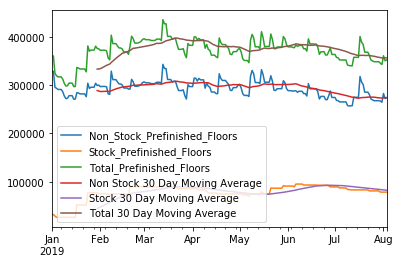

In [53]:
plotting_df = pd.DataFrame(index=dates)
# plotting_df.index = dates
plotting_df['Non_Stock_Prefinished_Floors'] = total_diff_df['Prefinished Flooring'] - stock_diff_df['Prefinished Flooring']
plotting_df['Stock_Prefinished_Floors'] = stock_diff_df['Prefinished Flooring']
plotting_df['Total_Prefinished_Floors'] = total_diff_df['Prefinished Flooring']
t_df = plotting_df.rolling(30).mean()
t_df.columns = ['Non Stock 30 Day Moving Average', 'Stock 30 Day Moving Average', 'Total 30 Day Moving Average']
plotting_df = pd.concat([plotting_df,t_df], axis=1)
plotting_df.plot()

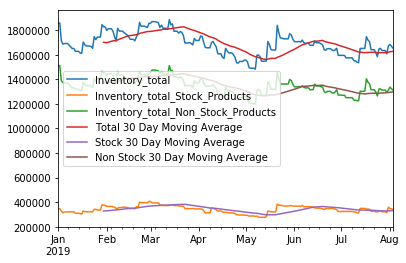

In [54]:
total_stock_plotting_df = pd.DataFrame(index=dates)
total_stock_plotting_df['Inventory_total'] = total_diff_df.sum(axis=1)
total_stock_plotting_df['Inventory_total_Stock_Products'] = stock_diff_df.sum(axis=1)
total_stock_plotting_df['Inventory_total_Non_Stock_Products'] = total_diff_df.sum(axis=1) - stock_diff_df.sum(axis=1)
t_df = total_stock_plotting_df.rolling(30).mean()
t_df.columns = ['Total 30 Day Moving Average', 'Stock 30 Day Moving Average', 'Non Stock 30 Day Moving Average']
total_stock_plotting_df = pd.concat([total_stock_plotting_df,t_df], axis=1)
total_stock_plotting_df.plot()

## Calculating average days to sell.

In [55]:
# Calculate the average inventory value from the beginning of the year
ew

In [56]:
po_df = pd.read_csv('Purchase_Orders_Flattened.csv',)

In [57]:
po_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 8 columns):
Supplier            1950 non-null object
CreatedOn           1950 non-null object
CompletedDate       1950 non-null object
Time_To_Complete    1950 non-null object
Total               1950 non-null float64
Guid                1950 non-null object
SupplierCode        1950 non-null object
SupplierName        1950 non-null object
dtypes: float64(1), object(7)
memory usage: 122.3+ KB


In [58]:
po_df.head()

Supplier   CreatedOn  \
0  {'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...  2018-04-08   
1  {'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...  2018-04-08   
2  {'Guid': '997d9738-72e7-4d21-a648-32d763dd990e...  2018-04-08   
3  {'Guid': 'd320ea27-5022-44fe-b03a-7038f3e85d65...  2018-04-08   
4  {'Guid': '0871166d-a9b7-439c-afdf-3f67c82ba5c4...  2018-04-08   

  CompletedDate            Time_To_Complete    Total  \
0    2018-04-09   1 days 05:37:10.548000000  8006.86   
1    2018-04-09   1 days 05:30:08.766000000   440.00   
2    2018-04-23  15 days 07:14:04.960000000  1428.48   
3    2018-05-14  36 days 00:39:22.999000000   432.00   
4    2018-04-25  17 days 01:34:46.965000000  2201.92   

                                   Guid                    SupplierCode  \
0  d320ea27-5022-44fe-b03a-7038f3e85d65                    American OEM   
1  d320ea27-5022-44fe-b03a-7038f3e85d65                    American OEM   
2  997d9738-72e7-4d21-a648-32d763dd990e           GLITSA AMERICAN, INC.   
3  d320ea27-5022-44fe-b03a-7038f3e85d65                    American OEM   
4  0871166d-a9b7-439c-afdf-3f67c82ba5c4  DESIGN HARDWOOD PRODUCTS, INC.   

                     SupplierName  
0                    American OEM  
1                    American OEM  
2           GLITSA AMERICAN, INC.  
3                    American OEM  
4  DESIGN HARDWOOD PRODUCTS, INC.

In [59]:
po_df['CreatedOn'] = pd.to_datetime(po_df.CreatedOn)
po_df['CompletedDate'] = pd.to_datetime(po_df.CompletedDate)
po_df.CreatedOn = pd.DatetimeIndex(po_df.CreatedOn).normalize()
po_df.CompletedDate = pd.DatetimeIndex(po_df.CompletedDate).normalize()

In [60]:
daily_purchases_df = po_df.groupby('CompletedDate').sum()

In [61]:
daily_purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 308 entries, 2018-04-09 to 2019-08-02
Data columns (total 1 columns):
Total    308 non-null float64
dtypes: float64(1)
memory usage: 4.8 KB


In [62]:
daily_purchases_df.columns=['DatePurchaseTotal']
daily_purchases_df[datetime(2019,1,1):]

DatePurchaseTotal
CompletedDate                   
2019-01-02               6020.88
2019-01-03                 40.00
2019-01-04              10596.74
2019-01-07               4848.10
2019-01-08               4617.92
2019-01-10                579.22
2019-01-11               9936.74
2019-01-14                659.22
2019-01-15               2313.23
2019-01-16              49487.20
2019-01-17               7079.86
2019-01-18               5915.76
2019-01-21               2253.80
2019-01-22               1242.19
2019-01-23              55832.95
2019-01-24               4633.79
2019-01-25              19041.96
2019-01-28              55768.20
2019-01-29                953.09
2019-01-30               8171.44
2019-01-31               8371.66
2019-02-01              18138.25
2019-02-04               1547.90
2019-02-05               2887.02
2019-02-07              54761.70
2019-02-08              14641.90
2019-02-11               3688.94
2019-02-14               6601.99
2019-02-15              10468.17
2019-02-18                265.00
...                          ...
2019-06-14               3770.43
2019-06-17               3896.71
2019-06-18               3238.92
2019-06-20              13320.55
2019-06-21              30211.93
2019-06-24              12445.25
2019-06-26              16453.94
2019-06-27              18344.31
2019-06-28               8533.20
2019-07-01               7305.35
2019-07-02               6983.46
2019-07-03               3778.20
2019-07-08               3038.22
2019-07-09               1878.06
2019-07-10              63218.56
2019-07-12              56086.52
2019-07-15               5254.90
2019-07-16              76670.73
2019-07-17               1327.81
2019-07-18               2382.43
2019-07-19               7040.27
2019-07-24              51100.18
2019-07-25               8211.36
2019-07-26                967.46
2019-07-27                355.00
2019-07-29              14899.94
2019-07-30              47277.15
2019-07-31              24910.46
2019-08-01               6679.58
2019-08-02               7355.12

[138 rows x 1 columns]

In [63]:
daily_inv_val_with_purchases_df = pd.merge(total_diff_df, daily_purchases_df, how='left',left_index=True, right_index=True)

In [64]:
daily_inv_val_with_purchases_df.DatePurchaseTotal=daily_inv_val_with_purchases_df.DatePurchaseTotal.fillna(value=0.0)

In [65]:
# Get the inventory total values for each day
p = daily_inv_val_with_purchases_df.Total.values

In [66]:
len(p)

215

In [67]:
len(p)

215

In [68]:
p[0]

928360.8850000001

In [69]:
# Remove the first value, and append a zero value to the end of the array
np.delete(p, 0)
np.append(p,np.array([0]))
daily_inv_val_with_purchases_df['Next_Day_Inventory'] = p

In [70]:
# Calculate cogs = initial inventory + purchases - final inventory
daily_cost_of_goods_sold = daily_inv_val_with_purchases_df.Total + daily_inv_val_with_purchases_df.DatePurchaseTotal - daily_inv_val_with_purchases_df.Next_Day_Inventory

In [72]:
daily_inv_val_with_purchases_df['COGS'] = daily_cost_of_goods_sold.cumsum()

In [73]:
daily_inv_val_with_purchases_df['InventoryTurns'] = daily_inv_val_with_purchases_df.COGS / daily_inv_val_with_purchases_df.AverageInventory 


In [74]:
daily_inv_val_with_purchases_df['time_delta'] = daily_inv_val_with_purchases_df.index - datetime(2019,1,1)

# daily_inv_val_with_purchases_df['AverageDaysToSell'] = daily_inv_val_with_purchases_df.InventoryTurns

In [75]:
daily_inv_val_with_purchases_df['AverageDaysToSell'] = daily_inv_val_with_purchases_df.time_delta / daily_inv_val_with_purchases_df.InventoryTurns


/Users/jon/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py:523: RuntimeWarning: invalid value encountered in true_divide
  result = self._data / other


In [76]:
daily_inv_val_with_purchases_df.AverageDaysToSell

2019-01-01                        NaT
2019-01-02   154 days 04:33:56.058516
2019-01-03   294 days 13:36:06.961365
2019-01-04   159 days 11:39:09.834850
2019-01-05   212 days 22:45:42.637567
2019-01-06   266 days 04:27:08.296959
2019-01-07   247 days 09:56:27.019713
2019-01-08   236 days 16:53:23.521591
2019-01-09   269 days 08:53:01.114301
2019-01-10   295 days 09:44:03.155617
2019-01-11   239 days 06:45:18.611338
2019-01-12   261 days 11:22:53.508531
2019-01-13   285 days 05:52:14.736580
2019-01-14   303 days 13:16:59.208264
2019-01-15   306 days 15:26:38.497770
2019-01-16   145 days 20:49:57.911295
2019-01-17   148 days 00:28:13.362244
2019-01-18   147 days 05:51:33.013852
2019-01-19   155 days 10:34:16.537430
2019-01-20   164 days 01:49:30.789509
2019-01-21   168 days 23:33:02.457121
2019-01-22   175 days 03:54:34.899907
2019-01-23   119 days 12:42:51.340225
2019-01-24   124 days 18:13:33.594502
2019-01-25   116 days 00:24:29.326280
2019-01-26   121 days 12:56:27.991975
2019-01-27  

In [77]:
daily_inv_val_with_purchases_df.AverageDaysToSell.iloc[1:]
daily_inv_val_with_purchases_df.AverageDaysToSell.iloc[1]

Timedelta('154 days 04:33:56.058516')

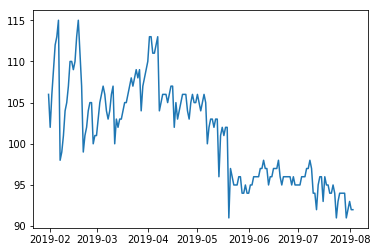

In [80]:
plt.plot(daily_inv_val_with_purchases_df.AverageDaysToSell.iloc[30:].apply(lambda x: x.days))